In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import re
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns; sns.set()

In [2]:
#To test NaiveBayes implementation we will try classifying spam messages
df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
#explore class frequencies
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [4]:
#divide data into train and test sets
idx = np.arange(df.shape[0])
np.random.seed(17)
np.random.shuffle(idx)

train_set_size = int(df.shape[0] * 0.8)

train_set = df.iloc[idx[:train_set_size]]
test_set = df.iloc[idx[train_set_size:]]

In [5]:
print(f'Train set has shape: {train_set.shape}')
print(f'Test set has shape: {test_set.shape}')

Train set has shape: (4457, 2)
Test set has shape: (1115, 2)


In [6]:
#func for cleaning single message from symbols, leaving only letters a-z and numbers 0-9
def clean_message(msg):
    msg = msg.lower()
    pattern = re.compile('\w+')
    nums_letters = re.findall(pattern, msg)
    result = ' '.join(nums_letters)
    return result

In [7]:
#preprocessing step
def preprocess_data(train_set, test_set):
    train_set_x = [clean_message(string).split() for string in train_set['v2']]
    train_set_x = np.array(train_set_x, dtype=object)
    train_set_y = train_set['v1'].to_numpy()
    
    test_set_x = [clean_message(string).split() for string in test_set['v2']]
    test_set_x = np.array(test_set_x, dtype=object)
    test_set_y = test_set['v1'].to_numpy()
    
    return train_set_x, train_set_y, test_set_x, test_set_y

train_set_x, train_set_y, test_set_x, test_set_y = preprocess_data(train_set, test_set)

In [8]:
#helper function for NaiveBayes
def words_classes(X_train, y_train):
    '''
    Returns arrays of unique words in each class and their union(totally 3 lists)
    '''
    all_words_list = set()
    ham_words_list = set()
    spam_words_list = set()
    
    for i, row in enumerate(X_train):
        if y_train[i] == 'ham':
            ham_words_list = ham_words_list.union(set(row))
        else:
            spam_words_list = spam_words_list.union(set(row))
    
    all_words_list = np.array(list(ham_words_list | spam_words_list))
    ham_words_list = np.array(list(ham_words_list))
    spam_words_list = np.array(list(spam_words_list))
    
    return all_words_list, ham_words_list, spam_words_list

In [9]:
class NaiveBayes:

    def __init__(self, alpha):
        self.alpha = alpha      #coefficient of Laplace smoothing
        
        self.train_set_x = None
        self.train_set_y = None
        
        self.all_words_list = []
        self.ham_words_list = []
        self.spam_words_list = []

        self.ham_words_dict = {}
        self.spam_words_dict = {}
        
        self.prior_ham_prob = None
        self.prior_spam_prob = None
    
    
    def fit(self, train_set_x, train_set_y):
        '''
        This function calculates the probability of each word in both categories
        and a prior probability of each category
        '''

        self.all_words_list, self.ham_words_list, self.spam_words_list = words_classes(train_set_x, train_set_y)
        
        ham_counter = Counter()
        spam_counter = Counter()
        
        for i, row in enumerate(train_set_x):
            (ham_counter.update if train_set_y[i] == 'ham' else spam_counter.update)(row)
        
        ham_words_total = sum(ham_counter.values())
        spam_words_total = sum(spam_counter.values())
        
        for word in self.all_words_list:
            if word in ham_counter.keys():
                self.ham_words_dict[word] = (ham_counter[word] + self.alpha) / (ham_words_total + 
                                                                                self.alpha*len(self.all_words_list))
            else:
                self.ham_words_dict[word] = self.alpha / (ham_words_total + self.alpha*len(self.all_words_list))
            
            if word in spam_counter.keys():
                self.spam_words_dict[word] = (spam_counter[word] + self.alpha) / (spam_words_total + 
                                                                                  self.alpha*len(self.all_words_list))
            else:
                self.spam_words_dict[word] = self.alpha / (spam_words_total + self.alpha*len(self.all_words_list))
        
        n_ham_emails = train_set_x[train_set_y == 'ham'].shape[0]
        n_observations = train_set_x.shape[0]
        
        self.prior_ham_prob = n_ham_emails / n_observations
        self.prior_spam_prob = 1 - self.prior_ham_prob
       
    
    def predict(self, test_set_x):
        '''
        This function calculates probabilities of belonging to ham and spam category and depending on them
        assigns label to an observation
        '''
        
        y_pred = []
        for row in test_set_x:
            ham_prob = np.log(self.prior_ham_prob)
            spam_prob = np.log(self.prior_spam_prob)
            for word in row:
                if word not in self.all_words_list:
                    continue
                ham_prob += np.log(self.ham_words_dict[word])
                spam_prob += np.log(self.spam_words_dict[word])
            
            y_pred.append('ham' if ham_prob > spam_prob else 'spam')
        
        return np.array(y_pred)

In [10]:
#initialize model with alpha=1 which corresponds to add-one smoothing
nbc = NaiveBayes(alpha=1)
nbc.fit(train_set_x, train_set_y)
y_predictions = nbc.predict(test_set_x)

<AxesSubplot:>

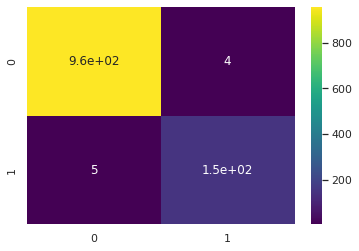

In [11]:
#build confusion matrix
conf_mat = confusion_matrix(test_set_y, y_predictions)
sns.heatmap(conf_mat, cmap='viridis', annot=True, cbar=True)

In [12]:
print(classification_report(test_set_y, y_predictions, target_names=['ham', 'spam']))

              precision    recall  f1-score   support

         ham       0.99      1.00      1.00       961
        spam       0.97      0.97      0.97       154

    accuracy                           0.99      1115
   macro avg       0.98      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115

